In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install deap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 2.8 MB/s eta 0:00:00


8/8 [==============================] - 1s 4ms/step
GA-LSTM Accuracy: 96.16%
Average LSTM AUC: 0.99
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      1551
           1       0.96      0.94      0.95       950

    accuracy                           0.96      2501
   macro avg       0.96      0.96      0.96      2501
weighted avg       0.96      0.96      0.96      2501



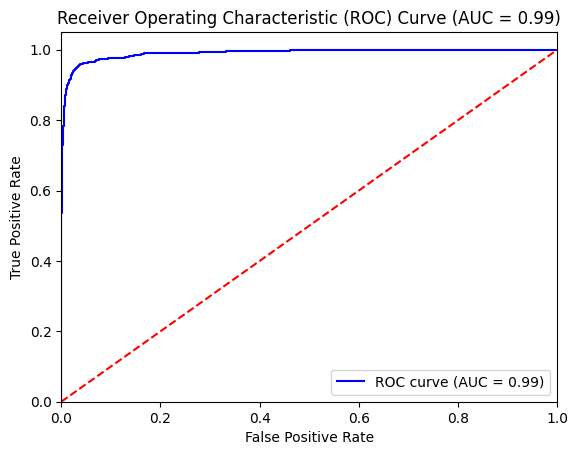

1/1 [==============================] - 0s 25ms/step
The image is classified as: Normal


In [ ]:
import numpy as np
import cv2
import os
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
from deap import base, creator, tools, algorithms
import matplotlib.pyplot as plt
import tensorflow as tf

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.resize(img, (224, 224))
            images.append(img)
    return np.array(images)

normal_images = load_images_from_folder('/content/drive/MyDrive/Brain_Data_Organised/Normal')
stroke_images = load_images_from_folder('/content/drive/MyDrive/Brain_Data_Organised/Stroke')

normal_labels = np.zeros(len(normal_images))
stroke_labels = np.ones(len(stroke_images))

X = np.concatenate((normal_images, stroke_images), axis=0)
y = np.concatenate((normal_labels, stroke_labels), axis=0)
X = X / 255.0

lb = LabelBinarizer()
y = lb.fit_transform(y)

datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.2,
                             height_shift_range=0.2, shear_range=0.2,
                             zoom_range=0.2, horizontal_flip=True)

def extract_features(model, X):
    features = model.predict(X, batch_size=32)
    return features

vgg_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
X_cnn = extract_features(vgg_model, X)

X_cnn = X_cnn.reshape(X_cnn.shape[0], -1)

if "FitnessMax" not in creator.__dict__:
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
if "Individual" not in creator.__dict__:
    creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual,
                 toolbox.attr_bool, n=X_cnn.shape[1])
toolbox.register("population", tools.initRepeat, list,
                 toolbox.individual)

def eval_individual(individual, y_train, X_train):
    selected_indices = [i for i in range(len(individual)) if individual[i] == 1]
    if len(selected_indices) == 0:
        return 0,

    X_train_selected = X_train[:, selected_indices]

    model = Sequential([Dense(128, activation='relu', input_shape=(X_train_selected.shape[1],)),
                        Dense(1, activation='sigmoid')])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train_selected, y_train, epochs=3, batch_size=32, verbose=0)

    accuracy = model.evaluate(X_train_selected, y_train, verbose=0)[1]
    return accuracy,

toolbox.register("evaluate", eval_individual, X_train=None)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

def genetic_feature_selection(y_train, X_train, n_gen=10, pop_size=20):
    population = toolbox.population(n=pop_size)
    for gen in range(n_gen):
        fitnesses = list(map(lambda ind: eval_individual(ind, y_train, X_train), population))
        for ind, fit in zip(population, fitnesses):
            ind.fitness.values = fit

        population = algorithms.varAnd(population, toolbox, cxpb=0.5, mutpb=0.2)
        population = toolbox.select(population, len(population))

    best_individual = tools.selBest(population, k=1)[0]
    selected_features = [i for i in range(len(best_individual)) if best_individual[i] == 1]

    return selected_features

all_y_true = []
all_y_pred_proba = []

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
accuracies = []
roc_aucs = []

X_cnn = extract_features(vgg_model, X)
X_cnn = X_cnn.reshape(X_cnn.shape[0], -1)

for train_index, test_index in kf.split(X_cnn, y):
    X_train, X_test = X_cnn[train_index], X_cnn[test_index]
    y_train, y_test = y[train_index], y[test_index]

    selected_features = genetic_feature_selection(y_train, X_train)

    X_train_selected = X_train[:, selected_features]
    X_test_selected = X_test[:, selected_features]

    X_train_reshaped = X_train_selected.reshape(X_train_selected.shape[0], 1, X_train_selected.shape[1])
    X_test_reshaped = X_test_selected.reshape(X_test_selected.shape[0], 1, X_test_selected.shape[1])

    lstm_model = Sequential()
    lstm_model.add(Input(shape=(1, X_train_selected.shape[1])))
    lstm_model.add(LSTM(128, activation='relu', return_sequences=True))
    lstm_model.add(Dropout(0.5))
    lstm_model.add(LSTM(64))
    lstm_model.add(Dropout(0.5))
    lstm_model.add(Dense(1, activation='sigmoid'))

    lstm_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=10)

    lstm_model.fit(X_train_reshaped, y_train, epochs=150, validation_data=(X_test_reshaped, y_test),
                    callbacks=[early_stopping], verbose=0)

    _, accuracy = lstm_model.evaluate(X_test_reshaped, y_test, verbose=0)
    y_pred_proba = lstm_model.predict(X_test_reshaped).flatten()

    all_y_true.extend(y_test.flatten())
    all_y_pred_proba.extend(y_pred_proba)

    roc_auc = roc_auc_score(y_test.flatten(), y_pred_proba)
    roc_aucs.append(roc_auc)
    accuracies.append(accuracy)

average_accuracy = np.mean(accuracies) * 100
average_auc = np.mean(roc_aucs)

print(f'GA-LSTM Accuracy: {average_accuracy:.2f}%')
print(f'Average LSTM AUC: {average_auc:.2f}')

print(classification_report(all_y_true, (np.array(all_y_pred_proba) > 0.5).astype(int)))

fpr, tpr, thresholds = roc_curve(all_y_true, all_y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', label='ROC curve (AUC = %0.2f)' % average_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic (ROC) Curve (AUC = {average_auc:.2f})')
plt.legend(loc='lower right')
plt.show()

lstm_model.save('stroke_classification_model.keras')

def classify_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Image at path {image_path} could not be loaded.")

    img_resized = cv2.resize(img, (224, 224)) / 255.0
    img_features = extract_features(vgg_model, np.array([img_resized]))

    img_features_reshaped = img_features.reshape(1, -1)[:, selected_features]
    img_features_reshaped_lstm_input = img_features_reshaped.reshape(1, 1, img_features_reshaped.shape[1])

    prediction = lstm_model.predict(img_features_reshaped_lstm_input)

    return "Stroke" if prediction > 0.5 else "Normal"

image_path_to_classify = '/content/drive/MyDrive/Brain_Data_Organised/Normal/100 (17).jpg'  # Replace with your image path
classification_result = classify_image(image_path_to_classify)
print(f'The image is classified as: {classification_result}')